In [1]:
# Global/WindowsApps (3.9.13)
!pip3 install --user fredapi
!pip3 install --user matplotlib
!pip3 install --user numpy
!pip3 install --user scipy
!pip3 install --user pandas
!pip3 install --user seaborn
!pip3 install --user sklearn
!pip3 install --user pandas_datareader
!pip3 install --user yfinance
!pip3 install --user finance-datareader
!pip3 install --user mplfinance
!pip3 install --user plotly

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import FinanceDataReader as fdr
from fredapi import Fred
import datetime, os

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import warnings
warnings.filterwarnings('ignore', 'The \'unit\' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.')

/tmp/ipykernel_25811/3511201693.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# This project is rework dynamicAA.ipynb in same folder
#
# 1. Get data from Yahoo Finance
# 2. Setup simulation parameters same as SimEnv
# 3. Buy all portfolio at setted date
# 4. Sell all portfolio at setted date
# 5. Calculate return of portfolio
#

# class Ticker (same as SimEnv)
# class Portfolio
# class SimProc
# class Simutils

In [4]:
class Cash:
    def __init__(self, start_date, end_date, isDollar=True):
        self.ticker_name = 'CMA'
        self.start_date = start_date
        self.end_date = end_date
        self.isDollar = isDollar
        self.data = self.get_data()

    def get_interest_rate(self)->float:
        interest_rate_year = 0.02
        interest_rate_day = 1.0+(interest_rate_year) / 365
        return interest_rate_day

    def get_data(self)->pd.DataFrame:
        interest_rate = self.get_interest_rate()
        # dataframe is power of interest_rate from start_date to end_date
        df_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        df = pd.DataFrame(index=pd.date_range(self.start_date, self.end_date), columns=df_columns)
        df.index.name = 'Date'
        days = lambda x: (x - df.index[0]).days
        df = df.apply(lambda x: interest_rate ** days(x.index))
        if not self.isDollar:
            exchange_df = self.get_exchange(df)
            df = df.mul(exchange_df)
        df = df.ffill()
        return df

    def get_exchange(self,df)->pd.DataFrame:
        if not os.path.exists('stock_dfs'):
            os.makedirs('stock_dfs')

        csv_file_path = 'stock_dfs/{}_{}_{}_{}.csv'.format('USD_KRW', self.start_date, self.end_date, 'won')
        if not os.path.exists(csv_file_path):
            exchange_df = fdr.DataReader('USD/KRW', self.start_date, self.end_date)
            exchange_df = exchange_df.resample('D').ffill()
            exchange_df.to_csv(csv_file_path)
        else:
            exchange_df = pd.read_csv(csv_file_path, index_col='Date', parse_dates=True)
        
        ret  = df.mul(exchange_df)
        return ret
    
class Ticker:
    # Each ticker class has ticker_name, weight for portfolio, and buy/sell date
    def __init__(self, ticker_name, weight, start_date, end_date, isDollar=True):
        self.ticker_name = ticker_name
        self.weight = weight
        self.start_date = start_date
        self.end_date = end_date
        self.isDollar = isDollar

    def load(self):
        if self.ticker_name == 'CASH':
            self.ticker_name = 'CMA'
            self.data = Cash(self.start_date, self.end_date, self.isDollar).data
        else:
            self.data = self.get_data()
            if not self.isDollar:
                self.data = self.get_exchange(self.data)
        self.data = self.data * self.weight
        self.data = self.data.ffill()
        return self

    def get_data(self):
        if not os.path.exists('stock_dfs'):
            os.makedirs('stock_dfs')
        csv_file_path = 'stock_dfs/{}_{}_{}_{}.csv'.format(self.ticker_name, self.start_date, self.end_date, 'dollar' if self.isDollar else 'won')
        if not os.path.exists(csv_file_path):
            yf.pdr_override()
            df_price = pdr.get_data_yahoo(self.ticker_name, start=self.start_date, end=self.end_date)
            df_price = df_price.resample('D').ffill().bfill()
            # fill not exist date
            df_price = df_price.reindex(pd.date_range(self.start_date, self.end_date), method='ffill')
            df_price = df_price.bfill()
            df_price.index.name = 'Date'
            df_price.to_csv(csv_file_path)
        else:
            df_price = pd.read_csv(csv_file_path, index_col='Date', parse_dates=True)
        return df_price

    def get_exchange(self,df)->pd.DataFrame:
        if not os.path.exists('stock_dfs'):
            os.makedirs('stock_dfs')

        csv_file_path = 'stock_dfs/{}_{}_{}_{}.csv'.format('USD_KRW', self.start_date, self.end_date, 'won')
        if not os.path.exists(csv_file_path):
            exchange_df = fdr.DataReader('USD/KRW', self.start_date, self.end_date)
            exchange_df = exchange_df.resample('D').ffill()
            exchange_df.to_csv(csv_file_path)
        else:
            exchange_df = pd.read_csv(csv_file_path, index_col='Date', parse_dates=True)
        
        ret  = df.mul(exchange_df)
        return ret
    

    # override operator +: 
    def __add__(self, other):
        if self.data.empty:
            return other
        if other.data.empty:
            return self
        if self.isDollar != other.isDollar:
            raise ValueError('Ticker data is not same currency')
        if self.start_date != other.start_date or self.end_date != other.end_date:
            raise ValueError('Ticker data is not same date')
        if self.weight+other.weight > 1.0:
            raise ValueError('Ticker weight is over 1.0')

        ticker_name = self.ticker_name + '+' + other.ticker_name
        ret = Ticker(self.ticker_name, self.weight + other.weight, self.start_date, self.end_date, self.isDollar)
        ret.data = self.data + other.data
        return ret


if __name__ == '__main__':
    # Test code
    ticker1 = Ticker('SPY', 0.5, '2020-01-01', '2020-12-31').load()
    ticker2 = Ticker('QQQ', 0.1, '2020-01-01', '2020-12-31').load()
    ticker3 = Ticker('SQQQ',0.4, '2020-01-01', '2020-12-31').load()
    portfolio = ticker1 + ticker2 + ticker3

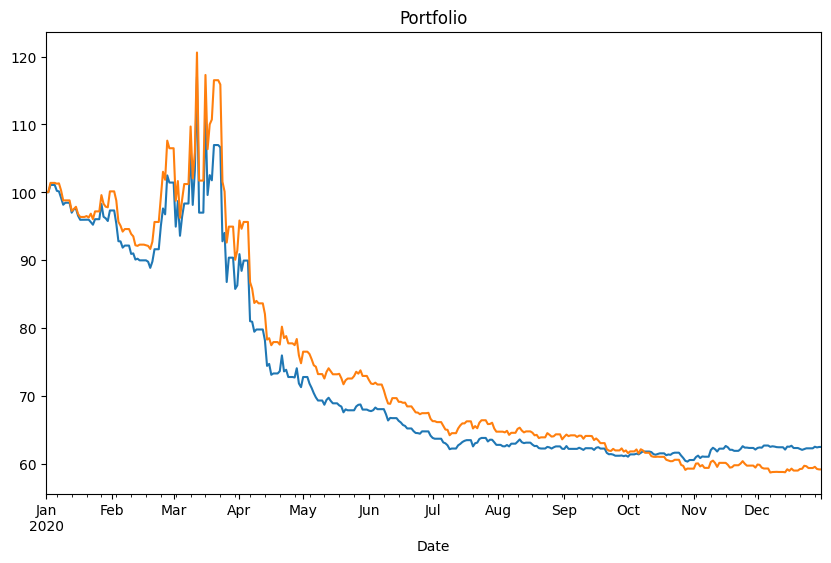

In [7]:
class Tactic:
    def __init__(self, tactic_name, ticker_list:list):
        self.tactic_name = tactic_name

    def rebalance(self, score:float):
        # Rebalance each tickers weight and dates
        pass
    
    def score(self)->float:
        score = 0
        return score

class Portfolio:
    # This class is submodel of SimProc
    # Input as ticker list ,budget and tactic 
    # Output as portfolio return which is used as simulation score
    # 1. Get class ticker list
    # 2. Get data from Yahoo Finance if the ticker is valid
    # 3. Calculate return of portfolio given weight 
    # 4. return score for SimProc.
    def __init__(self, ticker_list:list, budget:float, tactic:Tactic):
        self.ticker_list = ticker_list
        self.budget = budget
        self.tactic = tactic

    def load(self):
        self.data = pd.DataFrame()
        for ticker in self.ticker_list:
            self.data[ticker.ticker_name] = ticker.load().data['Close']
        self.data['Total'] = self.data.sum(axis=1)
        # Normalize to budget
        self.data = self.data / self.data.iloc[0] * self.budget
        return self

if __name__ == '__main__':
    # Test code
    ticker1 = Ticker('SPY', 0.5, '2020-01-01', '2020-12-31', 1).load()
    ticker2 = Ticker('QQQ', 0.1, '2020-01-01', '2020-12-31', 1).load()
    ticker3 = Ticker('SQQQ',0.4, '2020-01-01', '2020-12-31', 1).load()
    portfolio = Portfolio([ticker1, ticker2, ticker3], 100, None).load()
    plot = portfolio.data['Total'].plot(figsize=(10, 6), title='Portfolio')

    # Test code
    ticker1 = Ticker('SPY', 0.5, '2020-01-01', '2020-12-31', 0).load()
    ticker2 = Ticker('QQQ', 0.1, '2020-01-01', '2020-12-31', 0).load()
    ticker3 = Ticker('SQQQ',0.4, '2020-01-01', '2020-12-31', 0).load()
    portfolio = Portfolio([ticker1, ticker2, ticker3], 100, None).load()
    plot = portfolio.data['Total'].plot(figsize=(10, 6), title='Portfolio')